In [1]:
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import torch
import torch.nn as nn
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from IPython.display import clear_output
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import math

Лучшие параметры для модели, полученные с помощью байесовской оптимизации

In [2]:
best = {'loss': 0.02089968614280224,
  'params': {'adaptive_size': 70,
   'first_layer': 10,
   'second_layer': 6,
   'third_layer': 5,
   'upsample_1': 24,
   'upsample_2': 32,
   'upsample_3': 52}}

Загрузка данных

In [3]:
with open('data_train_dict_torch.pkl', 'rb') as f:
    data_train = pickle.load(f)

with open('data_test_dict_torch.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [4]:
min_channels = []
max_channels = []
train_dims = [100, 120, 140, 160, 180]
for we, sn in np.random.permutation([*product(train_dims, train_dims)]):
    min_channels.append(data_train[f'{we}x{sn}'].transpose(0, 1).reshape(15, -1).min(dim=1)[0])
    max_channels.append(data_train[f'{we}x{sn}'].transpose(0, 1).reshape(15, -1).max(dim=1)[0])
min_scale = torch.stack(min_channels).min(dim=0)[0]
max_scale = torch.stack(max_channels).max(dim=0)[0]

In [5]:
def scale_batch(batch, min_scale, max_scale):
    min = min_scale[None,...,None, None].to(batch.device)
    max = max_scale[None,...,None, None].to(batch.device)
    return (batch - min) / (max - min)

In [6]:
def iterate_minibatches(*tensors, batch_size, shuffle=True, epochs=1,
                        allow_incomplete=True, callback=lambda x:x):
    indices = np.arange(len(tensors[0]))
    upper_bound = int((np.ceil if allow_incomplete else np.floor) (len(indices) / batch_size)) * batch_size
    epoch = 0
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for batch_start in callback(range(0, upper_bound, batch_size)):
            batch_ix = indices[batch_start: batch_start + batch_size]
            batch = [tensor[batch_ix] for tensor in tensors]
            yield batch if len(tensors) > 1 else batch[0]
        epoch += 1
        if epoch >= epochs:
            break

Определение модели

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels=15, 
                    conv_kernel_0 = 3, adaptive_size = 90, 
                    conv_kernel_1 = 3, pool_kernel_1 = 3, pool_stride_1 = 2, 
                    conv_kernel_2 = 3, pool_kernel_2 = 3, pool_stride_2 = 2,
                    conv_kernel_3 = 3, pool_kernel_3 = 3, pool_stride_3 = 2,
                    upsample_1 = 16,
                    upsample_2 = 24,
                    upsample_3 = 52,
                    first_layer = 10, second_layer = 6, third_layer = 1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=15, kernel_size=conv_kernel_0),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(adaptive_size, adaptive_size)), 
            
            nn.Conv2d(in_channels=15, out_channels=first_layer, kernel_size=conv_kernel_1),
            nn.BatchNorm2d(first_layer),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_1, stride=pool_stride_1), # a = math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1

            nn.Conv2d(in_channels=first_layer, out_channels=second_layer, kernel_size=conv_kernel_2),
            nn.BatchNorm2d(second_layer),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_2, stride=pool_stride_2), # b = math.ceil((a - (conv_kernel_2 - 1)) / pool_stride_2) - 1

            nn.Conv2d(in_channels=second_layer, out_channels=third_layer, kernel_size=conv_kernel_3),
            nn.BatchNorm2d(third_layer),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_3, stride=pool_stride_3), # c = math.ceil((b - (conv_kernel_3 - 1)) / pool_stride_3) - 1

            nn.Flatten(),
        )
        self.encoder = self.encoder.float() # c = math.ceil((math.ceil((math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1 - (conv_kernel_2 - 1)) / pool_stride_2) - 1 - (conv_kernel_3 - 1)) / pool_stride_3) - 1

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (third_layer, int(math.ceil((math.ceil((math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1 - (conv_kernel_2 - 1)) / pool_stride_2) - 1 - (conv_kernel_3 - 1)) / pool_stride_3) - 1), 
                            int(math.ceil((math.ceil((math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1 - (conv_kernel_2 - 1)) / pool_stride_2) - 1 - (conv_kernel_3 - 1)) / pool_stride_3) - 1))),
            
            nn.ConvTranspose2d(in_channels=third_layer, out_channels=second_layer, kernel_size=conv_kernel_3),
            nn.Upsample(size=(upsample_1, upsample_1)),
            nn.ConvTranspose2d(in_channels=second_layer, out_channels=first_layer, kernel_size=conv_kernel_2),
            nn.Upsample(size=(upsample_2, upsample_2)),
            nn.ConvTranspose2d(in_channels=first_layer, out_channels=15, kernel_size=conv_kernel_1),
            nn.Upsample(size=(upsample_3, upsample_3)),
            nn.ConvTranspose2d(in_channels=15, out_channels=15, kernel_size=conv_kernel_0),
        )
        self.decoder = self.decoder.float()

    def forward(self, features):
        emb = self.encoder(features)
        reconstructed = self.decoder(emb)
    
        _, _, w, h = features.shape
        reconstructed = nn.Upsample(size=(w, h))(reconstructed)
    
        if reconstructed.shape != features.shape:
            print(reconstructed.shape)
            print(features.shape)
            assert False
        return reconstructed

In [34]:
device = 'cuda'
model = Autoencoder(adaptive_size=70,
   first_layer=10,
   second_layer=6,
   third_layer=5,
   upsample_1=24,
   upsample_2=32,
   upsample_3=52).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [35]:
losses = []
test_loss = defaultdict(list)
penalty = 0
min_loss = 10

In [43]:
def learn(penalty, min_loss, visualize=True, iterations = 100):
    for epoch in trange(iterations):
        loss_tmp = []
        for we, sn in np.random.permutation([*product(train_dims, train_dims)]):
            for batch in iterate_minibatches(data_train[f'{we}x{sn}'], batch_size=40):
                opt.zero_grad()
                batch = scale_batch(batch.to(device), min_scale, max_scale)
                out = model(batch)
                loss = criterion(out, batch)
                loss.backward()
                opt.step()
                loss_tmp.append(loss.item())
        losses.append(np.mean(loss_tmp))
        for we, sn in [*product(train_dims, train_dims)]:
            test_batch = scale_batch(data_test[f'{we}x{sn}'].to(device), min_scale, max_scale)
            out = model(test_batch)
            test_loss[f'{we}x{sn}'].append(criterion(out, test_batch).item())
        if visualize:
            clear_output(True)
            plt.figure(figsize=[12, 6])
            plt.plot(losses, label='train')
            mse_test = np.array([np.array(test_loss[f'{we}x{sn}']) for we, sn in [*product(train_dims, train_dims)]]).mean(0)
            plt.plot(mse_test, label='test')
            plt.title('Зависимость loss на тренировочном датасете и тестовом от числа итераций')
            plt.ylabel('loss')
            plt.tight_layout()

            if (mse_test[-1] > min_loss) or math.isclose(mse_test[-1], min_loss, rel_tol=0.002):
                penalty += 1
                if penalty > 15:
                    break
            elif mse_test[-1] < min_loss:
                # torch.save(model.state_dict(), 'channels_model_weights.pth')
                min_loss = mse_test[-1]
                penalty = 0
            plt.grid()
            plt.legend()
            plt.show()
    return (penalty, min_loss) 

In [ ]:
penalty, min_loss = learn(penalty, min_loss, True, 50)

In [46]:
print(f'min_loss: {min_loss}')
print(f'epochs_total: {losses.__len__()}')

min_loss: 0.01755062911659479
min_loss_val: 0.016693033277988434
epochs_total: 212


# Получение графиков для анализа модели

In [ ]:
l_arr = np.array([np.array(test_loss[f'{we}x{sn}']) for we, sn in [*product(train_dims, train_dims)]]).mean(0)

plt.subplot(2, 1, 1)
plt.plot(np.arange(1, l_arr.shape[0] + 1), losses, color='b')
plt.title("Loss")
plt.grid()
plt.xlabel("iterations")

plt.subplot(2, 1, 2)
plt.xlabel("iterations")
plt.plot(np.arange(1, l_arr.shape[0] + 1), l_arr, color='b')
plt.grid()
plt.title("MSE")

plt.tight_layout()
# plt.savefig("channels_mse_ans_loss")

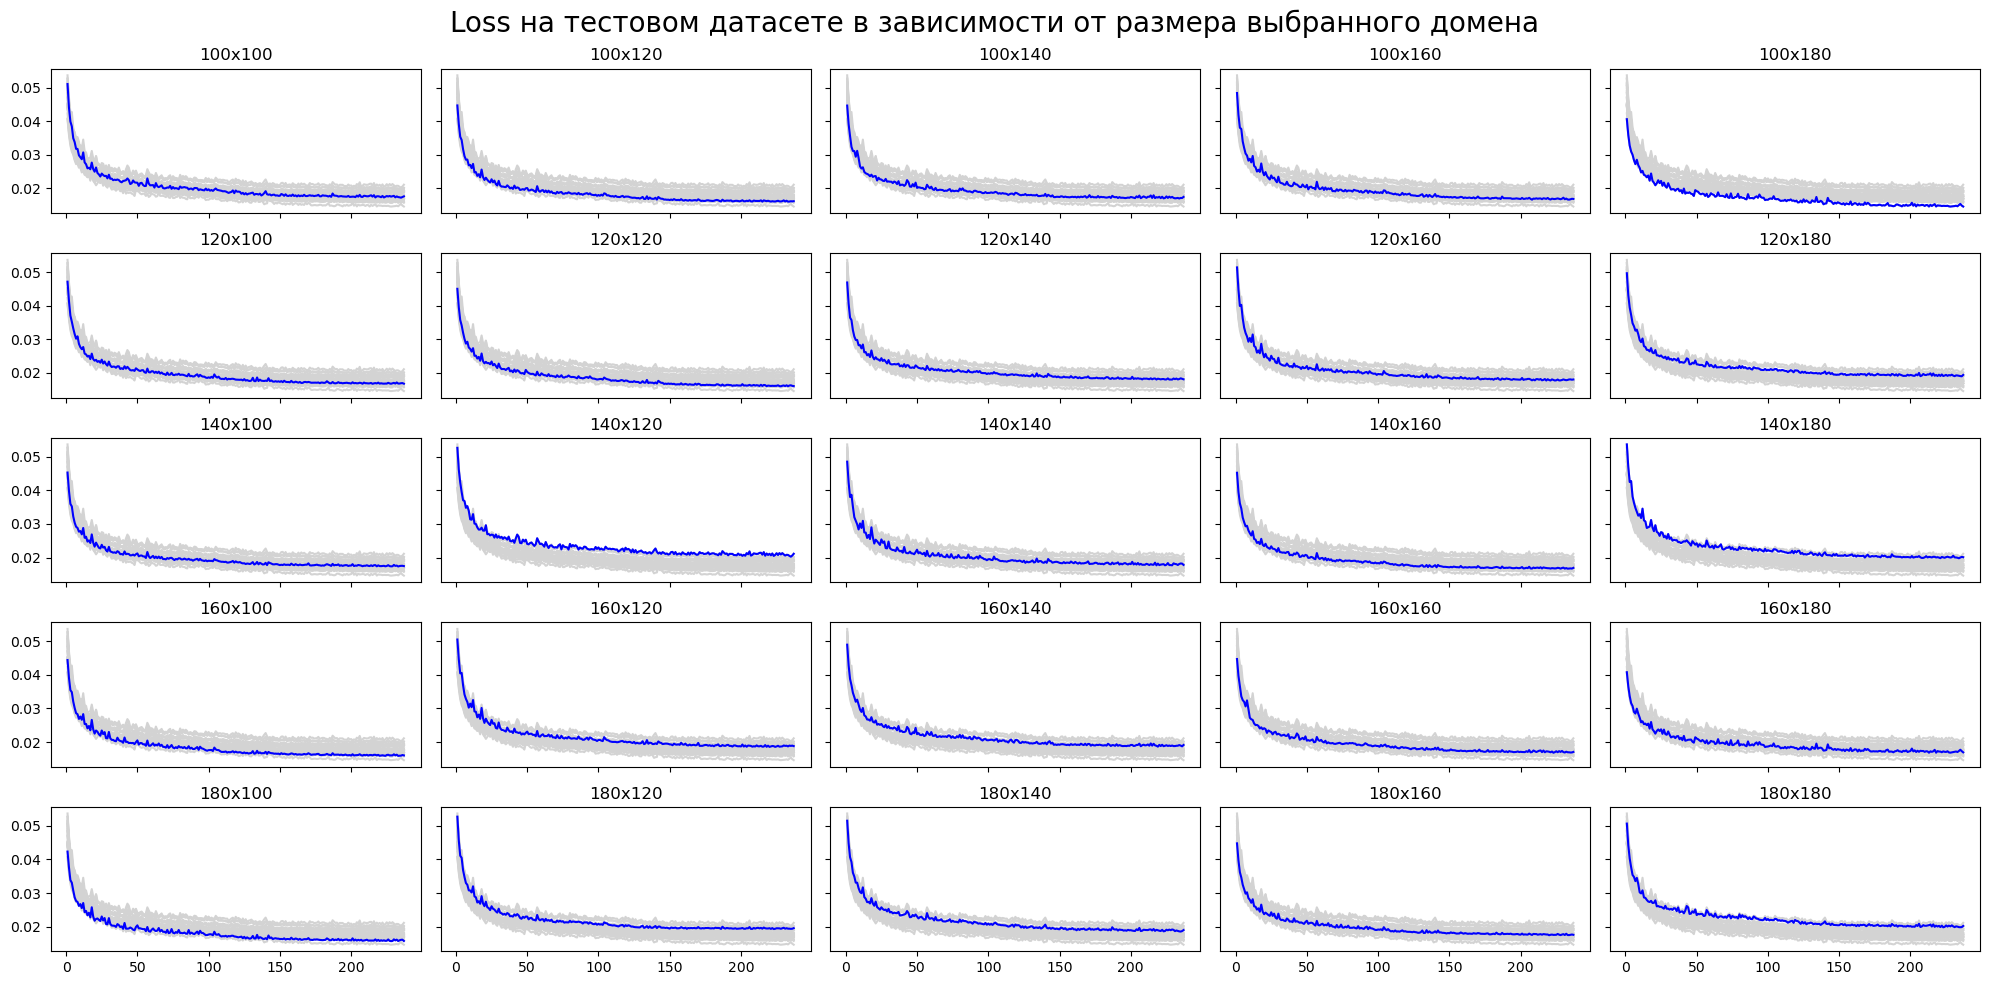

In [22]:
fig, axes = plt.subplots(5, 5, figsize=(20, 10), sharex=True, sharey=True)
for i in range(5):
    for j in range(5):
        for we, sn in [*product(train_dims, train_dims)]:
            axes[i, j].plot(np.arange(1, l_arr.shape[0] + 1), np.array(test_loss[f'{we}x{sn}']), color='lightgray')
        
        axes[i, j].plot(np.arange(1, l_arr.shape[0] + 1), np.array(test_loss[f'{train_dims[i]}x{train_dims[j]}']), color='b')
        axes[i, j].set_title(f"{train_dims[i]}x{train_dims[j]}")
fig.suptitle("Loss на тестовом датасете в зависимости от размера выбранного домена", fontsize=20)
fig.align_xlabels()
plt.tight_layout()

# plt.savefig("channels_loss_sep_sizes")

In [23]:
arr = np.array([np.array(test_loss[f'{we}x{sn}'])[-1] for we, sn in [*product(train_dims, train_dims)]])
arr.resize((5, 5))
arr = arr[::-1, ::]

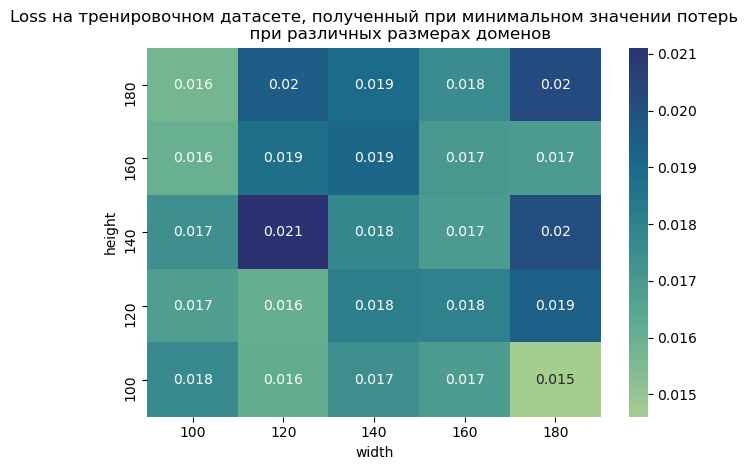

In [24]:
ar = pd.DataFrame(data=arr, index=train_dims[::-1], columns=train_dims)

sns.heatmap(ar, annot=True, cmap="crest")
plt.title('''Loss на тренировочном датасете, полученный при минимальном значении потерь
          при различных размерах доменов''')
plt.xlabel("width")
plt.ylabel("height")
plt.tight_layout()
# plt.savefig("channels_heatmap")